## Attribution Modelling and Budget Optimization

In [1]:
import pandas as pd
import itertools
from collections import defaultdict
from itertools import permutations,combinations
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
from gekko import GEKKO
from pandas_profiling import ProfileReport
from PIL import Image
import requests
import os

In [2]:
os.getcwd()

'C:\\Users\\jbhsm\\Project_Pro\\Attribution Modelling and Budget Optimization\\lib'

In [3]:
os.listdir('C:\\Users\\jbhsm\\Project_Pro\\Attribution Modelling and Budget Optimization\\input')

['attribution_data.csv', 'data.zip']

In [4]:
data_path='C:\\Users\\jbhsm\\Project_Pro\\Attribution Modelling and Budget Optimization\\input\\attribution_data.csv'

In [5]:
# Reading the data frame 
data=pd.read_csv(data_path)
data.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [6]:
data.shape

(586737, 6)

In [8]:
#Creating exploratory data analysis report using pandas profiling python module

profile = ProfileReport(data, title='Attribution Data Report', explorative=True) 

In [9]:
#Displaying the report

profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
profile.to_file("Report.html") 

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Single Touch Attribution Models

* Single-touch attribution models assign 100% of conversion credit to one marketing channel disregarding any number of channels visited by an user.
* Type of Model include:
    * Last Touch Attribution Model
    * First Touch Attribution Model
    * Last Non Direct Model

#### 1.Last-Touch Attribution Model

*   Last-touch attribution assigns 100% of the credit to the last marketing touchpoint.

*   The argument behind this approach is that the last touch is all that matters because it resulted in the actual conversion, but in reality it doesn’t tell the whole story. Your customers are likely engaging with your brand across multiple touchpoints on various channels before they convert.

In [35]:
def last_touch_model(dt, conv_col,channel_col):         #Defining function for last touch model
    last_touch=dt.loc[dt[conv_col]==1]          #Extracting rows where conversion is 1 
    res_last_touch=pd.DataFrame(round(last_touch[channel_col].value_counts(normalize=True)*100,2))      #Calculating the weightage
    res_last_touch.columns=['Weightage(%)']   
    return res_last_touch

In [36]:
last_touch=last_touch_model(data, 'conversion', 'channel')  #Calling the last touch model function
last_touch

,Weightage(%)
Facebook,30.05
Paid Search,25.78
Online Video,19.32
Instagram,12.72
Online Display,12.13


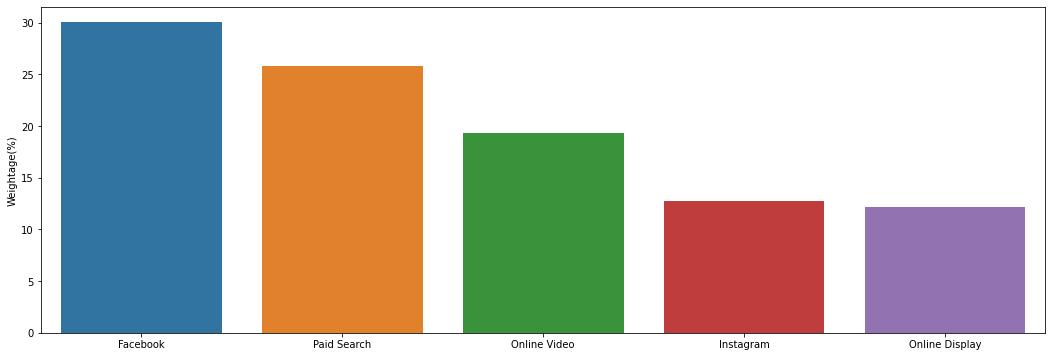

In [15]:
#Plotting the weightage with respect to channels
plt.subplots(figsize=(18, 6))
sns.barplot(y='Weightage(%)', x=last_touch.index, data=last_touch)
plt.show()

#### 2.First-Touch Attribution Model

* With a first-touch attribution model, your first marketing interaction receives 100% of the credit.

* If one is mainly focused on widening top of your funnel, this is a useful model. It highlights the channels that first introduced a customer to your brand.

* The problem with this model is that it ignores all subsequent touches, and therefore provides no insight into your down-funnel metrics.

In [37]:
def first_touch_model(dt, conv_col,channel_col,user_id):
    temp=dt.loc[dt[conv_col]==1]          #Saving the dataframe where all the conversions are 1 into temp variable
    first_touch=pd.DataFrame(dt.groupby(user_id).first(),index=dt[user_id])       #Grouping with respect to cookie and then keeping only the first instance of every cookie
    cookie_index=list(temp[user_id])      #making a list of cookie column of temp
    mid_first_touch=first_touch.loc[cookie_index]     #locating cookie index in the first touch dataframe
    res_first_touch=pd.DataFrame(round(mid_first_touch[channel_col].value_counts(normalize=True)*100,2))    #Calculating weightage
    res_first_touch.columns=['Weightage(%)']
    return res_first_touch

In [38]:
first_touch = first_touch_model(data, 'conversion', 'channel', 'cookie')
first_touch

,Weightage(%)
Facebook,32.59
Online Video,25.20
Paid Search,18.47
Instagram,14.78
Online Display,8.95


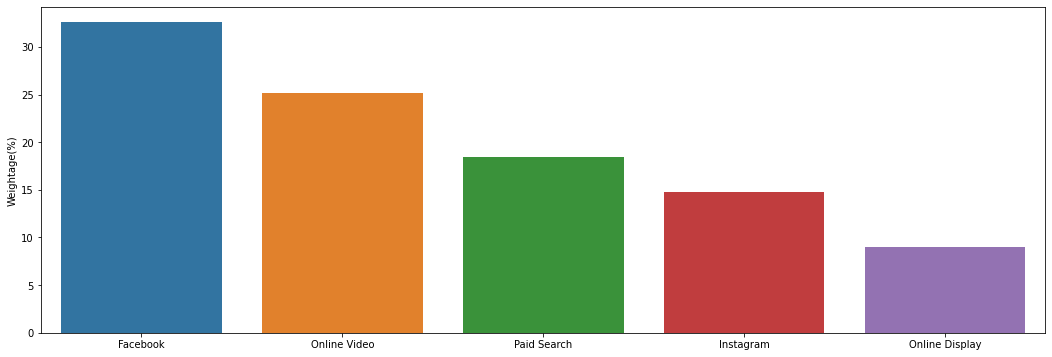

In [18]:
plt.subplots(figsize=(18, 6))
sns.barplot(y='Weightage(%)', x=first_touch.index, data=first_touch)
plt.show()

#### 3.Last-Non-direct Touch Attribution Model
* There is one small difference between last non-direct click attribution and last-click attribution. Direct traffic is ignored, and 100% of the credit is assigned to the last channel that the visitor engaged with before making a conversion. To explain this attribution model, we’ll need to change our customer journey slightly.

* This model is best if you want to fully understand the effectiveness of your final marketing activities without direct traffic getting in the way of your analysis. However, this model still doesn’t account for any of the other campaigns or channels the customer interacted with.

In [39]:
def last_non_direct_model(dt, conv_col, channel_col, user_id):
    slp=pd.DataFrame(dt.groupby(user_id).tail(2))     #Grouping by cookie and keeping the last two observation for each cookie
    temp=slp.loc[slp[conv_col]==1]
    last_non_direct=pd.DataFrame(slp.groupby(user_id).first(),index=slp[user_id])
    cookie_index=list(temp[user_id])
    mid_last_non_direct=last_non_direct.loc[cookie_index]
    res_last_non_direct=pd.DataFrame(round(mid_last_non_direct[channel_col].value_counts(normalize=True)*100,2))
    res_last_non_direct.columns=['Weightage(%)']
    return res_last_non_direct

In [40]:
last_non_direct = last_non_direct_model(data, 'conversion', 'channel', 'cookie')
last_non_direct

,Weightage(%)
Facebook,29.97
Paid Search,24.97
Online Video,20.47
Instagram,13.22
Online Display,11.37


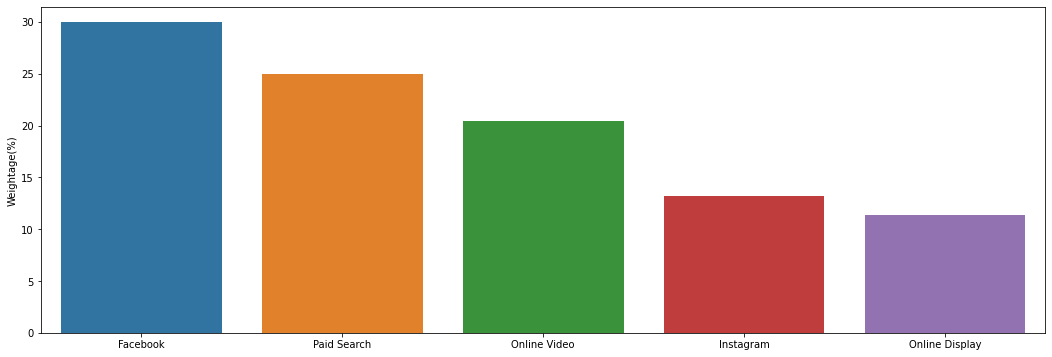

In [33]:
plt.subplots(figsize=(18, 6))
sns.barplot(y='Weightage(%)', x=last_non_direct.index, data=last_non_direct)
plt.show()

## Multi-Touch Models
* this type of models give credit to all touch points during the conversion process.

#### 1.Linear Attribution Model

* Linear attribution gives each touchpoint across the buyer journey the same amount of credit toward driving a sale. While this type of attribution considers every touchpoint in the buyer’s journey, it values every touchpoint evenly.

* The advantage of this model is that it is easy to implement and is better than all single-touch attribution models.

* The disadvantage however is that in reality, consumers aren’t equally impacted by every kind of touchpoint/channel. 

In [34]:
import copy

In [41]:
def linear_model(dt, conv_col, channel_col, user_id):

    #Keeping data of only those users who are getting converted at the end
    pd.options.mode.chained_assignment = None 
    temp=dt.loc[dt[conv_col]==1]
    cookie_index=list(temp[user_id])
    dt['new']=dt[user_id].isin(cookie_index)      
    y=dt['new'].isin([True])
    dt_conv=dt[y]

    temp=pd.DataFrame(dt_conv.groupby(user_id).tail(1))
    x=Counter(dt_conv[user_id])
    temp['click_count']=x.values()      #Click count is total number of channels visited by an user
    temp.set_index(user_id,inplace=True)
    count=Counter(dt_conv[user_id])
    dt_conv['clicks']=dt_conv[user_id].map(count)     #Adding click count to the filtered the data
    dt_conv=dt_conv.assign(click_per=lambda x: round(100/dt_conv['clicks'],2))      #Assigning the weightages in a linear fashion

    #Getting the mean weightage of every channels    
    res_linear=dt_conv.groupby(channel_col, as_index=False)['click_per'].mean()
    summ=res_linear['click_per'].sum()
    res_linear['Weightage(%)']=res_linear.apply(lambda x: round((x['click_per']/summ)*100,2),axis=1)
    res_linear.drop(['click_per'],inplace=True,axis=1)
    res_linear=res_linear.set_index(channel_col)
    res_linear.index.name=None
    return res_linear

In [42]:
linear = linear_model(data, 'conversion', 'channel', 'cookie')    #Calling the linear model function
linear

,Weightage(%)
Facebook,16.28
Instagram,16.56
Online Display,26.43
Online Video,13.11
Paid Search,27.63


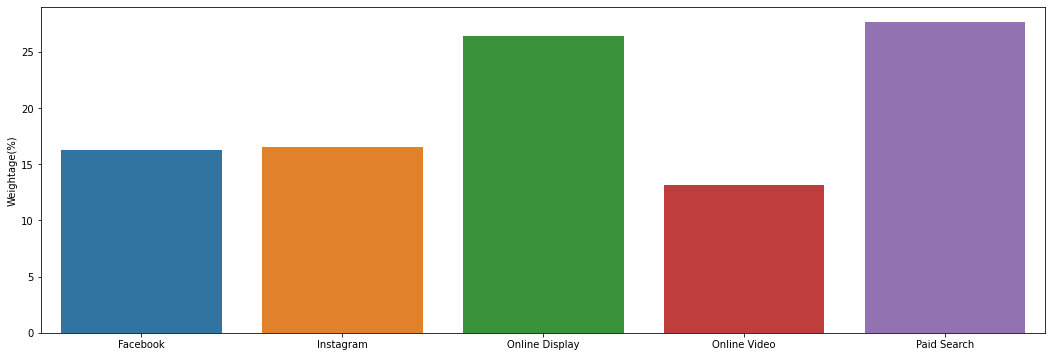

In [63]:
plt.subplots(figsize=(18, 6))
sns.barplot(y='Weightage(%)', x=linear.index, data=linear)
plt.show()

#### 2.Position Based (U-shaped) Attribution Model

* The Position-based attribution model (also called U-shaped attribution) splits the credit for a sale between first interaction and the moment it converts.

* 40% of the credit is given to each of these points, with the remaining 20% spread out between any other interactions that happened in the middle.

In [43]:
def calc_attribution(click_pos,total_clicks):
    #Assigning weightage according to the position of the channel
    default_att = 0.5       #if a user has visited only 2 channels 
    extreme_touch_att_1 = 0.4     #Assigining weightage to first and last channels
    intermed_att_1 = 0.2    #Total weightage for remaining channels
    
    if  total_clicks == 2:     
        return default_att
    
    elif total_clicks == 1:
        return 1
    else:
        if click_pos == total_clicks or click_pos ==1:
            return extreme_touch_att_1
        else:
            return intermed_att_1/(total_clicks-2)      #Giving equal weightage to all the mid channels from the remaining 20%

In [44]:
def u_shaped_model(dt, conv_col, channel_col, user_id):

    #Keeping data of only those users who are getting converted at the end
    pd.options.mode.chained_assignment = None     #Ignoring pandas warnings
    temp=dt.loc[dt[conv_col]==1]
    cookie_index=list(temp[user_id])
    dt['new']=dt[user_id].isin(cookie_index)
    y=dt['new'].isin([True])
    dt_conv=dt[y]

    count=Counter(dt_conv[user_id])
    dt_conv['clicks']=dt_conv[user_id].map(count)
    dt_conv['click_pos'] = dt_conv.groupby(user_id).cumcount() + 1      #Giving ranks to the channel for each user_id
    dt_Ushaped=dt_conv
    dt_Ushaped['U_Shape'] = dt_conv.apply(lambda val: round(calc_attribution(val.click_pos,val.clicks)*100,2),axis=1)

    #Getting the mean weightage of every channels
    res_Ushaped=dt_Ushaped.groupby(channel_col, as_index=False)['U_Shape'].mean()
    summ=res_Ushaped['U_Shape'].sum()
    res_Ushaped['Weightage(%)']=res_Ushaped.apply(lambda x: round((x['U_Shape']/summ)*100,2),axis=1)
    res_Ushaped.drop(['U_Shape'],inplace=True,axis=1)
    res_Ushaped=res_Ushaped.set_index(channel_col)
    res_Ushaped.index.name=None
    return res_Ushaped

In [45]:
u_shaped = u_shaped_model(data, 'conversion', 'channel', 'cookie')    #Calling u_shaped model function
u_shaped

,Weightage(%)
Facebook,16.28
Instagram,16.65
Online Display,26.61
Online Video,12.99
Paid Search,27.48


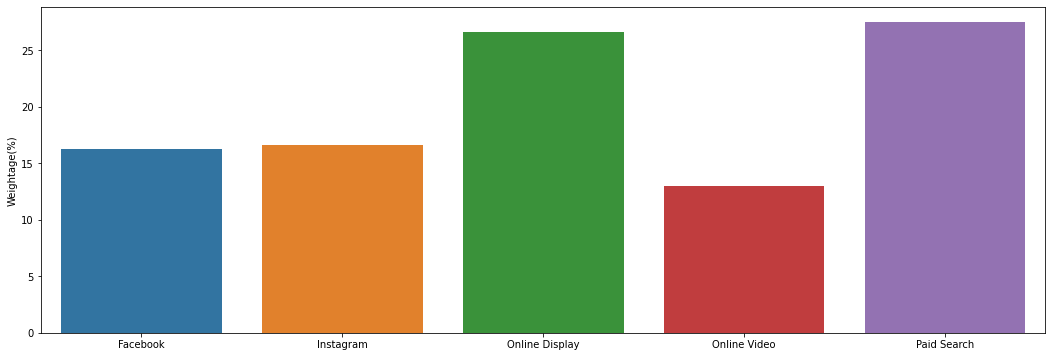

In [79]:
plt.subplots(figsize=(18, 6))
sns.barplot(y='Weightage(%)', x=u_shaped.index, data=u_shaped)
plt.show()

#### 3.Position Decay Attribution Model

* The Position Decay is a multi-touch attribution model that uses an algorithm which allocates points to all the channels used to convert, giving them credit in reverse order. This model assumes that an user's interest in a product grows with every interaction, and the last one is the most important, as it determines the users to convert. That’s why the highest score is attributed to the last channel; then the score decreases progressively for  every channel until the first one. 

In [46]:
def calc_attribution(click_pos,total_clicks):
    rel_pos = total_clicks - click_pos
    attribution = pow(2, -(rel_pos))       #Assigning weightage to channels in the negative power of 2 depending on their position
    return attribution

In [47]:
def pos_decay_model(dt, conv_col, channel_col, user_id):

    #Keeping data of only those users who are getting converted at the end
    pd.options.mode.chained_assignment = None
    temp=dt.loc[dt[conv_col]==1]
    cookie_index=list(temp[user_id])
    dt['new']=dt[user_id].isin(cookie_index)
    y=dt['new'].isin([True])
    dt_conv=dt[y]

    dt_conv['temp']=1
    count=Counter(dt_conv[user_id])
    dt_conv['clicks']=dt_conv[user_id].map(count)
    dt_conv=dt_conv.assign(click_per=lambda x: round(100/dt_conv['clicks'],2))
    dt_conv['click_pos'] = dt_conv.groupby(user_id).cumcount() + 1              #Giving ranks to channels according to user_id
    dt_conv['PosDecay'] = dt_conv.apply(lambda val: calc_attribution(val.click_pos,val.clicks)*100,axis=1)
    dt_pos_decay=dt_conv

    #Getting the mean weightage of every channels
    res_pos_decay=dt_pos_decay.groupby('channel', as_index=False)['PosDecay'].mean()
    sum=res_pos_decay['PosDecay'].sum()
    res_pos_decay['Weightage(%)']=res_pos_decay.apply(lambda x: round((x['PosDecay']/sum)*100,2),axis=1)
    res_pos_decay.drop(['PosDecay'], axis=1,inplace=True)
    res_pos_decay=res_pos_decay.set_index(channel_col)
    res_pos_decay.index.name=None
    return res_pos_decay

In [48]:
pos_decay = pos_decay_model(data, 'conversion', 'channel', 'cookie')
pos_decay

,Weightage(%)
Facebook,17.10
Instagram,17.14
Online Display,25.44
Online Video,14.68
Paid Search,25.64


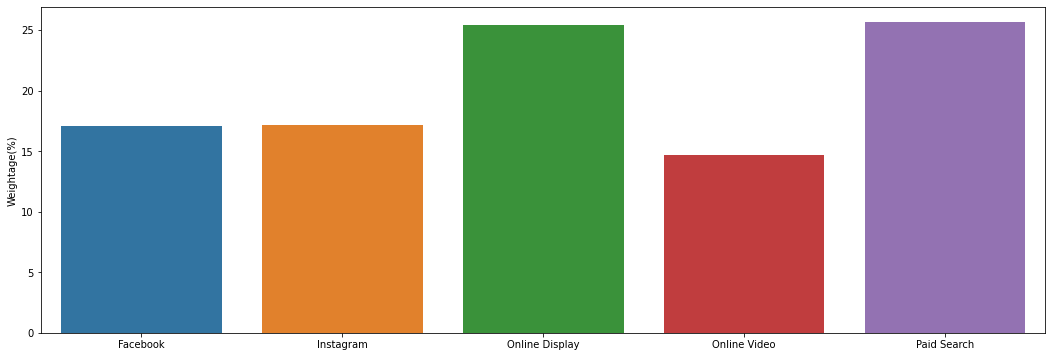

In [97]:
plt.subplots(figsize=(18, 6))
sns.barplot(y='Weightage(%)', x=pos_decay.index, data=pos_decay)
plt.show()

## III. Probabilistic Attribution Models

* Probabilistic Attribution uses statistical modeling and machine learning techniques to derive probability of conversion across all marketing touchpoints which can then be used to weight the value of each touchpoint preceding the conversion.

In [49]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
#     print(list_of_unique_channels)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}      #Creating all possible paths between any 2 channels

    #Getting the frequencies for all possible combinations
    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]       
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states

In [50]:
def transition_prob(trans_dict,list_of_paths):

    #Assigning probabilities to each combination of paths of length 2
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob

In [51]:
def transition_matrix(list_of_paths, transition_probabilities):

    #Creating a transition matrix using the probabilities of each paths of length 2
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix

In [52]:
def removal_effects(dt, conversion_rate):

    #Calculating the effect of channel if it was removed
    removal_effects_dict = {}
    channels = [channel for channel in dt.columns if channel not in ['Start','Null','Conversion']]
    for channel in channels:
        removal_dt = dt.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_dt.columns:
            row_sum = np.sum(list(removal_dt.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_dt.loc[column]['Null'] = null_pct
            removal_dt.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_dt[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_dt.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict

In [53]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}

In [54]:
def markov_model(df, conv_col, channel_col, user_id):
    pd.options.mode.chained_assignment = None 
    df = df.sort_values(user_id)
    df['visit_order'] = df.groupby(user_id).cumcount() + 1
  
    df_paths = df.groupby(user_id)[channel_col].aggregate(lambda x: x.unique().tolist()).reset_index()
    df_last_interaction = df.drop_duplicates(user_id, keep='last')[[user_id, conv_col]]
    df_paths = pd.merge(df_paths, df_last_interaction, how='left', on=user_id)

    df_paths['start'] = [["Start"] for i in range(len(df_paths[conv_col]))]
    df_paths['buff'] = [["Conversion"] for i in range(len(df_paths[conv_col]))]
    df_paths['null'] = [["Null"] for i in range(len(df_paths[conv_col]))]


    df_paths['path'] = np.where(df_paths[conv_col] == 0, df_paths['start'] + df_paths[channel_col] + df_paths['null'], df_paths['start'] + df_paths[channel_col] + df_paths['buff'])
    df_paths = df_paths[[user_id, 'path']]

    list_of_paths = df_paths['path']
    total_conversions = np.sum(a.count('Conversion') for a in df_paths['path'].tolist())
    base_conversion_rate = total_conversions / len(list_of_paths)
  
    trans_states = transition_states(list_of_paths)
    trans_prob = transition_prob(trans_states, list_of_paths)
    trans_matrix = transition_matrix(list_of_paths, trans_prob)
    removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)    #Creating a dictionary of the removal effect

    attributions = markov_chain_allocations(removal_effects_dict, total_conversions)    #Allocating markov chains
    res_markov=pd.DataFrame(attributions.values(),index=attributions.keys())
    res_markov.columns=['weightage']
    sum=res_markov['weightage'].sum()
    res_markov['Weightage(%)']=res_markov.apply(lambda x: round((x['weightage']/sum)*100,2),axis=1)
    res_markov.drop(['weightage'], axis=1,inplace=True)
    res_markov=res_markov.sort_index()
    return res_markov

In [55]:
markov = markov_model(data, 'conversion', 'channel', 'cookie')
markov

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


,Weightage(%)
Facebook,28.55
Instagram,15.76
Online Display,12.85
Online Video,15.38
Paid Search,27.46


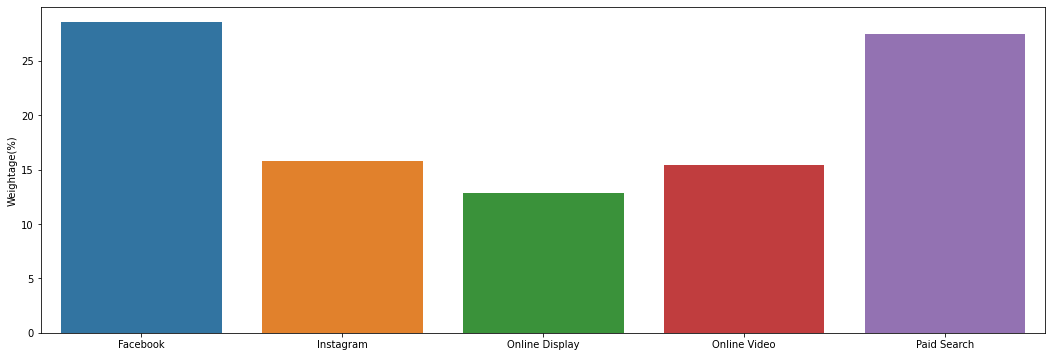

In [177]:
plt.subplots(figsize=(18, 6))
sns.barplot(y='Weightage(%)', x=markov.index, data=markov)
plt.show() 

#### 2.Shapley Value Model

* Shapley value provide a stable way to measure channel influence and fairly divide the credit for sales conversions between the channels, based on their individual contribution to the total payoff.

* As businesses strive for more accountability, efficiency, and data-driven decision making, cooperative game theory and the Shapley value provide marketing departments with an accurate and tailored solution for attribution that has the potential to deliver much more than the rules-based models are able to provide.

* Shapley Attribution model should be used when the number of channels for a particular campaign is 15 or more.

In [27]:
def power_set(List):

    #Creating a power set of a given list
    PS = [list(j) for i in range(len(List)) for j in itertools.combinations(List, i+1)]
    return PS

In [32]:
def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''

    
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return list(map(",".join,map(sorted,sub_channels)))

In [29]:
def v_function(A,C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionnary containing the number of conversions that each subset of channels has yielded.
    '''
    subsets_of_A = subsets(A)
    #print(subsets_of_A)
    #exit()
    worth_of_A=0
    for subset in subsets_of_A:
        #print("subset:", subset)
        if subset in C_values:
            #print("subset:", subset, "; Value:", C_values[subset])
            worth_of_A += C_values[subset]
    return worth_of_A

In [30]:
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

In [24]:
def calculate_shapley(df, col_name):
    '''
    This function returns the shapley values
            - df: A dataframe with the two columns: ['channels_subset', 'conversion_sum'].
            - col_name: A string that is the name of the column with conversions in the dataframe
            **Make sure that that each value in channel_subset is in alphabetical order. Facebook,Paid Search and Paid Search,Facebook are the same 
            in regards to this analysis and should be combined under Facebook,Paid Search.
            ***Be careful with the distinct number of channels because this can signifcantly slow the perfomance of this function.
    '''
    
    c_values = df.set_index("channels_subset").to_dict()[col_name]
    df['channels'] = df['channels_subset'].apply(lambda x: x if len(x.split(",")) == 1 else np.nan)
    channels = list(df['channels'].dropna().unique())
    
    v_values = {}
    for A in power_set(channels):
        v_values[','.join(sorted(A))] = v_function(A,c_values)
    #print(v_values)
    n=len(channels)
    shapley_values = defaultdict(int)
    for channel in channels:
        for A in v_values.keys():
            #print(A)
            if channel not in A.split(","):
                #print(channel)
                cardinal_A=len(A.split(","))
                A_with_channel = A.split(",")
                A_with_channel.append(channel)            
                A_with_channel=",".join(sorted(A_with_channel))
                # Weight = |S|!(n-|S|-1)!/n!
                weight = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
                # Marginal contribution = v(S U {i})-v(S)
                contrib = (v_values[A_with_channel]-v_values[A]) 
                shapley_values[channel] += weight * contrib
        # Add the term corresponding to the empty set
        shapley_values[channel]+= v_values[channel]/n 
        
    return shapley_values


In [31]:
def shapley_model(df, conv_col, channel_col, user_id):
    dt_paths = df.sort_values(channel_col).groupby(user_id)[channel_col].aggregate(lambda x: x.unique().tolist()).reset_index()
    dt_paths['channels']=[str(x) for x in dt_paths[channel_col]]
    channel_count=Counter(dt_paths['channels'])
    channel_ct=pd.DataFrame(channel_count.items())
    channel_ct[0] =  channel_ct[0].apply(lambda x: x.replace('[','').replace(']','').replace("'","").replace(", ",","))
    channel_ct.columns=['channels_subset','conversion_sum']
    attribution=calculate_shapley(channel_ct,'conversion_sum')
    res_shapley=pd.DataFrame(attribution.values(),index=attribution.keys())
    res_shapley.columns=['weightage']
    summ=res_shapley['weightage'].sum()
    res_shapley['Weightage(%)']=res_shapley.apply(lambda x: round((x['weightage']/summ)*100,2),axis=1)
    res_shapley.drop(['weightage'], axis=1,inplace=True)
    res_shapley = res_shapley.sort_index()
    return res_shapley

In [33]:
shapley=shapley_model(data, 'conversion', 'channel', 'cookie')
shapley

,Weightage(%)
Facebook,27.29
Instagram,13.11
Online Display,14.26
Online Video,14.27
Paid Search,31.06


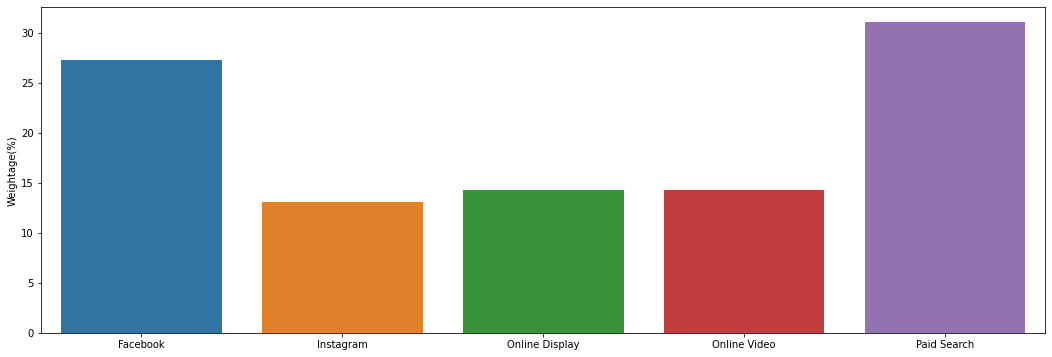

In [34]:
#visualizations
plt.subplots(figsize=(18, 6))
sns.barplot(y='Weightage(%)', x=shapley.index, data=shapley)
plt.show()

### Table of Result

In [56]:
Combined_dataframe = pd.concat([last_touch,first_touch,last_non_direct,linear,u_shaped,pos_decay,markov,shapley],axis=1)
Combined_dataframe.columns=['Last-Touch','First-Touch','Last-Non-direct','Linear','U-shaped','Position Decay','Markov','Shapley']
Combined_dataframe['Mean'] = round(Combined_dataframe.mean(axis=1),2)
Combined_dataframe

,Last-Touch,First-Touch,Last-Non-direct,Linear,U-shaped,Position Decay,Markov,Shapley,Mean
Facebook,30.05,32.59,29.97,16.28,16.28,17.10,28.55,27.29,24.76
Paid Search,25.78,18.47,24.97,27.63,27.48,25.64,27.46,31.06,26.06
Online Video,19.32,25.20,20.47,13.11,12.99,14.68,15.38,14.27,16.93
Instagram,12.72,14.78,13.22,16.56,16.65,17.14,15.76,13.11,14.99
Online Display,12.13,8.95,11.37,26.43,26.61,25.44,12.85,14.26,17.26


### Graphs

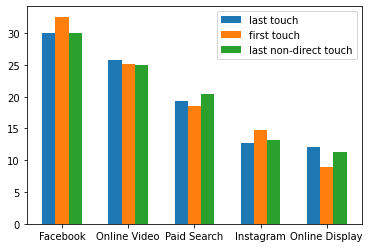

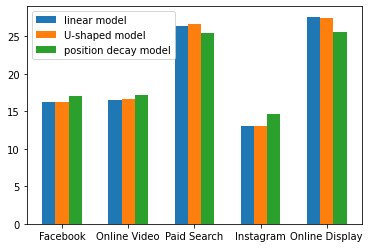

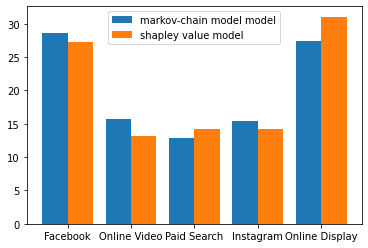

In [57]:
X_axis = np.arange(len(first_touch.index))
plt.bar(X_axis - 0.2, last_touch['Weightage(%)'],0.2,label='last touch')
plt.bar(X_axis , first_touch['Weightage(%)'],0.2,label='first touch')
plt.bar(X_axis + 0.2, last_non_direct['Weightage(%)'],0.2,label='last non-direct touch')
plt.xticks(X_axis, first_touch.index)
plt.legend()
plt.show()

print()

X_axis = np.arange(len(first_touch.index))
plt.bar(X_axis - 0.2, linear['Weightage(%)'],0.2,label='linear model')
plt.bar(X_axis , u_shaped['Weightage(%)'],0.2,label='U-shaped model')
plt.bar(X_axis + 0.2, pos_decay['Weightage(%)'],0.2,label='position decay model')
plt.xticks(X_axis, first_touch.index)
plt.legend()
plt.show()

print()

X_axis = np.arange(len(markov.index))
plt.bar(X_axis - 0.2, markov['Weightage(%)'],0.4,label='markov-chain model model')
plt.bar(X_axis + 0.2, shapley['Weightage(%)'],0.4,label='shapley value model')
plt.xticks(X_axis, first_touch.index)
plt.legend()
plt.show()

### Budget Optimization

In [66]:
m=GEKKO()
n=5
budget=int(input("Enter campaign budget: "))      #Taking input of the budget for a campaign

Enter campaign budget: 10000


In [70]:
coeff_A = Combined_dataframe['Mean'].tolist()

In [71]:
ch_names=list(sorted(Combined_dataframe.index))
ch_names

['Facebook', 'Instagram', 'Online Display', 'Online Video', 'Paid Search']

In [72]:
#Assigning lower bound and upper bound to each channel
x1 = m.Var(lb=100, ub=budget)       
x2 = m.Var(lb=100, ub=budget)
x3 = m.Var(lb=100, ub=budget)
x4 = m.Var(lb=100, ub=budget)
x5 = m.Var(lb=100, ub=budget)

In [73]:
for j in range(n):
    print("Channel",j+1,"should not exceed : ", end='')     #Taking input of upper bound spending on each channel
    z=int(input())
    m.Equation(globals()["x" + str(j+1)] <= z)

Channel 1 should not exceed : 2000
Channel 2 should not exceed : 3500
Channel 3 should not exceed : 2500
Channel 4 should not exceed : 3400
Channel 5 should not exceed : 3000


In [74]:
m.Equation(x1+x2+x3+x4+x5 <= budget)
m.Maximize(coeff_A[0]*x1 + coeff_A[1]*x2 + coeff_A[2]*x3 + coeff_A[3]*x4 + coeff_A[4]*x5)

In [75]:
m.solve(disp=False)
p1 = x1.value[0]
p2 = x2.value[0]
p3 = x3.value[0]
p4 = x4.value[0]
p5 = x5.value[0]

In [76]:
#Printing the budget along with the channel names
print('\n\nBudgets:\n\n')
print(ch_names[0] + ": " + str(round(p1,0)))
print(ch_names[1] + ": " + str(round(p2,0)))
print(ch_names[2] + ": " + str(round(p3,0)))
print(ch_names[3] + ": " + str(round(p4,0)))
print(ch_names[4] + ": " + str(round(p5,0)))



Budgets:


Facebook: 2000.0
Instagram: 2000.0
Online Display: 2500.0
Online Video: 500.0
Paid Search: 3000.0
